In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)


In [ ]:
latent_dim = 100
learning_rate = 1e-3
batch_size = 128
epochs = 20
kl_weight = 0.000075


In [ ]:
class VAE(nn.Module):
    def __init__(self, latent_dim=100):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # [B, 32, 16, 16]
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # [B, 64, 8, 8]
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # [B, 128, 4, 4]
            nn.ReLU(),
        )
        self.flatten = nn.Flatten()
        self.fc_mu = nn.Linear(128*4*4, latent_dim)
        self.fc_logvar = nn.Linear(128*4*4, latent_dim)
        self.fc_decode = nn.Linear(latent_dim, 128*4*4)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # [B, 64, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # [B, 32, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),   # [B, 3, 32, 32]
            nn.Sigmoid()
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x_enc = self.encoder(x)
        x_flat = self.flatten(x_enc)
        mu = self.fc_mu(x_flat)
        logvar = self.fc_logvar(x_flat)
        z = self.reparameterize(mu, logvar)
        x_dec = self.fc_decode(z).view(-1, 128, 4, 4)
        recon = self.decoder(x_dec)
        return recon, mu, logvar

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    kl_loss = torch.sum(-0.5 * (1 + logvar - mu.pow(2) - logvar.exp()))
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

In [ ]:
model = VAE(latent_dim=100).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss(reduction='sum')
epochs = 30

best_test_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device)
        optimizer.zero_grad()
        recon, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(recon, x, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Train Loss: {avg_train_loss:.4f}")

    # --- Evaluation ---
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for x, _ in test_loader:
            x = x.to(device)
            recon, mu, logvar = model(x)
            loss, _, _ = vae_loss(recon, x, mu, logvar)
            test_loss += loss.item()

    avg_test_loss = test_loss / len(test_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}] Test Loss: {avg_test_loss:.4f}")

    # --- Save Best Model ---
    if avg_test_loss < best_test_loss:
        best_test_loss = avg_test_loss
        torch.save(model.state_dict(), "best_vae.pth")
        print(f"✅ Best model saved at epoch {epoch+1} with test loss: {best_test_loss:.4f}")



Epoch 1/30: 100%|██████████| 391/391 [00:13<00:00, 28.04it/s]


Epoch [1/30] Train Loss: 68.6737
Epoch [1/30] Test Loss: 38.3294
✅ Best model saved at epoch 1 with test loss: 38.3294


Epoch 2/30: 100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


Epoch [2/30] Train Loss: 33.4319
Epoch [2/30] Test Loss: 29.3445
✅ Best model saved at epoch 2 with test loss: 29.3445


Epoch 3/30: 100%|██████████| 391/391 [00:13<00:00, 28.67it/s]


Epoch [3/30] Train Loss: 26.6091
Epoch [3/30] Test Loss: 24.5784
✅ Best model saved at epoch 3 with test loss: 24.5784


Epoch 4/30: 100%|██████████| 391/391 [00:13<00:00, 29.66it/s]


Epoch [4/30] Train Loss: 23.1788
Epoch [4/30] Test Loss: 21.6748
✅ Best model saved at epoch 4 with test loss: 21.6748


Epoch 5/30: 100%|██████████| 391/391 [00:13<00:00, 29.98it/s]


Epoch [5/30] Train Loss: 20.9219
Epoch [5/30] Test Loss: 19.9641
✅ Best model saved at epoch 5 with test loss: 19.9641


Epoch 6/30: 100%|██████████| 391/391 [00:12<00:00, 30.29it/s]


Epoch [6/30] Train Loss: 19.6083
Epoch [6/30] Test Loss: 19.1898
✅ Best model saved at epoch 6 with test loss: 19.1898


Epoch 7/30: 100%|██████████| 391/391 [00:12<00:00, 30.27it/s]


Epoch [7/30] Train Loss: 18.8816
Epoch [7/30] Test Loss: 18.7618
✅ Best model saved at epoch 7 with test loss: 18.7618


Epoch 8/30: 100%|██████████| 391/391 [00:12<00:00, 30.19it/s]


Epoch [8/30] Train Loss: 18.2424
Epoch [8/30] Test Loss: 18.0934
✅ Best model saved at epoch 8 with test loss: 18.0934


Epoch 9/30: 100%|██████████| 391/391 [00:13<00:00, 29.36it/s]


Epoch [9/30] Train Loss: 17.9681
Epoch [9/30] Test Loss: 17.9608
✅ Best model saved at epoch 9 with test loss: 17.9608


Epoch 10/30: 100%|██████████| 391/391 [00:12<00:00, 30.19it/s]


Epoch [10/30] Train Loss: 17.7774
Epoch [10/30] Test Loss: 17.8964
✅ Best model saved at epoch 10 with test loss: 17.8964


Epoch 11/30: 100%|██████████| 391/391 [00:12<00:00, 30.08it/s]


Epoch [11/30] Train Loss: 17.5973
Epoch [11/30] Test Loss: 17.5772
✅ Best model saved at epoch 11 with test loss: 17.5772


Epoch 12/30: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


Epoch [12/30] Train Loss: 17.4992
Epoch [12/30] Test Loss: 17.5114
✅ Best model saved at epoch 12 with test loss: 17.5114


Epoch 13/30: 100%|██████████| 391/391 [00:13<00:00, 30.01it/s]


Epoch [13/30] Train Loss: 17.3997
Epoch [13/30] Test Loss: 17.4433
✅ Best model saved at epoch 13 with test loss: 17.4433


Epoch 14/30: 100%|██████████| 391/391 [00:13<00:00, 29.88it/s]


Epoch [14/30] Train Loss: 17.2751
Epoch [14/30] Test Loss: 17.6420


Epoch 15/30: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


Epoch [15/30] Train Loss: 17.2344
Epoch [15/30] Test Loss: 18.4210


Epoch 16/30: 100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


Epoch [16/30] Train Loss: 17.1376
Epoch [16/30] Test Loss: 17.2100
✅ Best model saved at epoch 16 with test loss: 17.2100


Epoch 17/30: 100%|██████████| 391/391 [00:13<00:00, 30.07it/s]


Epoch [17/30] Train Loss: 17.0165
Epoch [17/30] Test Loss: 17.1171
✅ Best model saved at epoch 17 with test loss: 17.1171


Epoch 18/30: 100%|██████████| 391/391 [00:13<00:00, 29.96it/s]


Epoch [18/30] Train Loss: 16.9516
Epoch [18/30] Test Loss: 17.1318


Epoch 19/30: 100%|██████████| 391/391 [00:13<00:00, 29.78it/s]


Epoch [19/30] Train Loss: 16.8489
Epoch [19/30] Test Loss: 17.1987


Epoch 20/30: 100%|██████████| 391/391 [00:12<00:00, 30.12it/s]


Epoch [20/30] Train Loss: 16.8513
Epoch [20/30] Test Loss: 17.7221


Epoch 21/30: 100%|██████████| 391/391 [00:12<00:00, 30.11it/s]


Epoch [21/30] Train Loss: 16.7491
Epoch [21/30] Test Loss: 17.0753
✅ Best model saved at epoch 21 with test loss: 17.0753


Epoch 22/30: 100%|██████████| 391/391 [00:12<00:00, 30.28it/s]


Epoch [22/30] Train Loss: 16.6901
Epoch [22/30] Test Loss: 17.1230


Epoch 23/30: 100%|██████████| 391/391 [00:12<00:00, 30.18it/s]


Epoch [23/30] Train Loss: 16.5925
Epoch [23/30] Test Loss: 16.9210
✅ Best model saved at epoch 23 with test loss: 16.9210


Epoch 24/30: 100%|██████████| 391/391 [00:13<00:00, 29.85it/s]


Epoch [24/30] Train Loss: 16.5702
Epoch [24/30] Test Loss: 16.8721
✅ Best model saved at epoch 24 with test loss: 16.8721


Epoch 25/30: 100%|██████████| 391/391 [00:12<00:00, 30.09it/s]


Epoch [25/30] Train Loss: 16.5625
Epoch [25/30] Test Loss: 16.9146


Epoch 26/30: 100%|██████████| 391/391 [00:12<00:00, 30.14it/s]


Epoch [26/30] Train Loss: 16.4896
Epoch [26/30] Test Loss: 16.9617


Epoch 27/30: 100%|██████████| 391/391 [00:13<00:00, 29.98it/s]


Epoch [27/30] Train Loss: 16.4944
Epoch [27/30] Test Loss: 17.2251


Epoch 28/30: 100%|██████████| 391/391 [00:13<00:00, 29.38it/s]


Epoch [28/30] Train Loss: 16.4327
Epoch [28/30] Test Loss: 16.9603


Epoch 29/30: 100%|██████████| 391/391 [00:13<00:00, 29.64it/s]


Epoch [29/30] Train Loss: 16.3588
Epoch [29/30] Test Loss: 16.9058


Epoch 30/30: 100%|██████████| 391/391 [00:13<00:00, 29.72it/s]


Epoch [30/30] Train Loss: 16.3472
Epoch [30/30] Test Loss: 17.0005


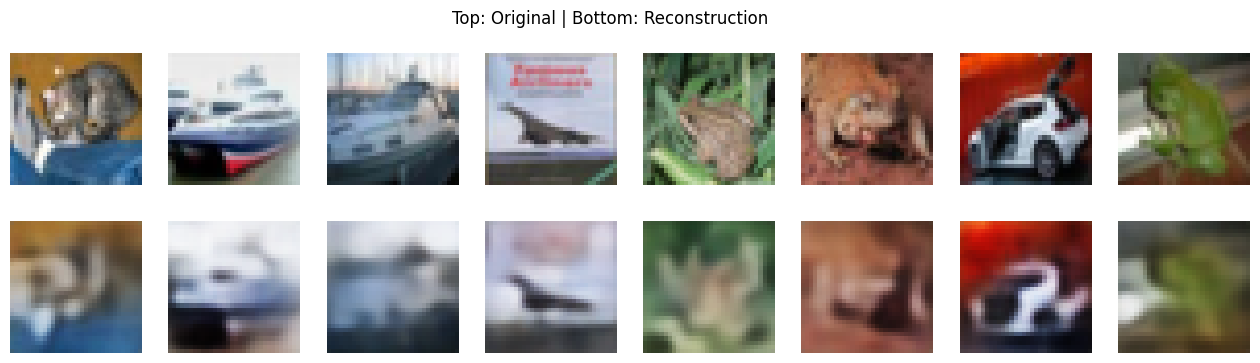

In [ ]:
model.eval()
with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)[:8]
    recon, _, _ = model(x)

    plt.figure(figsize=(16, 4))
    for i in range(8):
        plt.subplot(2, 8, i+1)
        plt.imshow(x[i].permute(1, 2, 0).cpu())
        plt.axis('off')

        plt.subplot(2, 8, i+9)
        plt.imshow(recon[i].permute(1, 2, 0).cpu())
        plt.axis('off')

    plt.suptitle("Top: Original | Bottom: Reconstruction")
    plt.show()

100%|██████████| 170M/170M [00:03<00:00, 43.7MB/s]
Epoch 1/20: 100%|██████████| 391/391 [00:11<00:00, 34.63it/s]


Epoch 1: Total=5274906.47, Recon=5273223.61, KL=22438069.07


Epoch 2/20: 100%|██████████| 391/391 [00:09<00:00, 41.61it/s]


Epoch 2: Total=4203206.42, Recon=4201354.85, KL=24687697.29


Epoch 3/20: 100%|██████████| 391/391 [00:09<00:00, 39.35it/s]


Epoch 3: Total=4023071.27, Recon=4021234.08, KL=24495935.40


Epoch 4/20: 100%|██████████| 391/391 [00:10<00:00, 36.98it/s]


Epoch 4: Total=3914220.09, Recon=3912376.88, KL=24576303.74


Epoch 5/20: 100%|██████████| 391/391 [00:09<00:00, 39.52it/s]


Epoch 5: Total=3834449.36, Recon=3832601.03, KL=24644403.77


Epoch 6/20: 100%|██████████| 391/391 [00:09<00:00, 39.54it/s]


Epoch 6: Total=3798413.81, Recon=3796585.59, KL=24376328.54


Epoch 7/20: 100%|██████████| 391/391 [00:09<00:00, 40.40it/s]


Epoch 7: Total=3780648.88, Recon=3778836.07, KL=24170798.78


Epoch 8/20: 100%|██████████| 391/391 [00:09<00:00, 40.91it/s]


Epoch 8: Total=3770061.95, Recon=3768261.85, KL=24001302.07


Epoch 9/20: 100%|██████████| 391/391 [00:09<00:00, 39.67it/s]


Epoch 9: Total=3759498.59, Recon=3757701.70, KL=23958447.43


Epoch 10/20: 100%|██████████| 391/391 [00:09<00:00, 39.67it/s]


Epoch 10: Total=3751496.66, Recon=3749709.55, KL=23828313.89


Epoch 11/20: 100%|██████████| 391/391 [00:09<00:00, 39.33it/s]


Epoch 11: Total=3743579.18, Recon=3741794.43, KL=23796757.95


Epoch 12/20: 100%|██████████| 391/391 [00:09<00:00, 39.56it/s]


Epoch 12: Total=3737650.70, Recon=3735872.61, KL=23707849.31


Epoch 13/20: 100%|██████████| 391/391 [00:09<00:00, 41.51it/s]


Epoch 13: Total=3733403.98, Recon=3731625.82, KL=23708612.40


Epoch 14/20: 100%|██████████| 391/391 [00:09<00:00, 39.46it/s]


Epoch 14: Total=3728756.53, Recon=3726977.77, KL=23716788.74


Epoch 15/20: 100%|██████████| 391/391 [00:09<00:00, 39.83it/s]


Epoch 15: Total=3725034.48, Recon=3723255.86, KL=23714797.91


Epoch 16/20: 100%|██████████| 391/391 [00:09<00:00, 39.38it/s]


Epoch 16: Total=3721021.37, Recon=3719246.38, KL=23666494.43


Epoch 17/20: 100%|██████████| 391/391 [00:10<00:00, 38.23it/s]


Epoch 17: Total=3717802.49, Recon=3716024.78, KL=23702855.98


Epoch 18/20: 100%|██████████| 391/391 [00:09<00:00, 40.50it/s]


Epoch 18: Total=3715478.64, Recon=3713699.99, KL=23715247.66


Epoch 19/20: 100%|██████████| 391/391 [00:09<00:00, 40.11it/s]


Epoch 19: Total=3712068.10, Recon=3710292.17, KL=23679109.08


Epoch 20/20: 100%|██████████| 391/391 [00:10<00:00, 38.81it/s]


Epoch 20: Total=3709730.31, Recon=3707951.08, KL=23723031.64


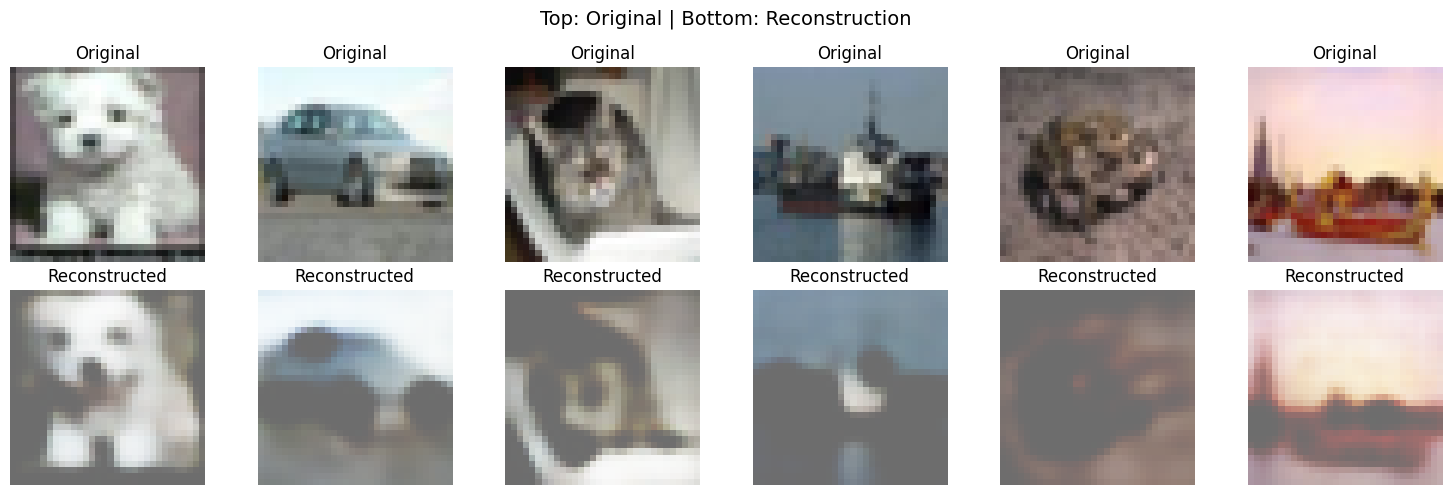

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import numpy as np
from tqdm import tqdm

# Device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Parameters
latent_dim = 100
learning_rate = 1e-3
batch_size = 128
epochs = 20
kl_weight = 0.000075

# CIFAR-10 loader
transform = transforms.ToTensor()
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)

# === VAE Model ===
class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args
    def forward(self, x):
        return x.view(x.size(0), *self.shape)

class Trim(nn.Module):
    def __init__(self):
        super(Trim, self).__init__()
    def forward(self, x):
        return x[:, :, :32, :32]

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1)
        self.flatten = nn.Flatten()

        self.fc_mu = nn.Linear(128 * 4 * 4, latent_dim)
        self.fc_logvar = nn.Linear(128 * 4 * 4, latent_dim)

        self.fc_decode = nn.Linear(latent_dim, 128 * 4 * 4)
        self.reshape = Reshape(128, 4, 4)

        self.deconv1 = nn.ConvTranspose2d(128, 64, 3, stride=2)
        self.deconv2 = nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1)
        self.deconv3 = nn.ConvTranspose2d(32, 3, 3, stride=2, padding=1)
        self.trim = Trim()

    def encode(self, x):
        x = F.silu(self.conv1(x))
        x = F.silu(self.conv2(x))
        x = F.silu(self.conv3(x))
        x = self.flatten(x)
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        eps = torch.randn_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)

    def decode(self, z):
        x = self.fc_decode(z)
        x = self.reshape(x)
        x = F.silu(self.deconv1(x))
        x = F.silu(self.deconv2(x))
        x = F.silu(self.deconv3(x))
        x = self.trim(x)
        return torch.sigmoid(x)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss(reduction='sum')

# === VAE Loss ===
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = criterion(recon_x, x)
    kl_loss = torch.sum(-0.5 * (1 + logvar - mu.pow(2) - logvar.exp()))
    total_loss = recon_loss + kl_weight * kl_loss
    return total_loss, recon_loss, kl_loss

# === Training ===
for epoch in range(epochs):
    model.train()
    total_loss, recon_sum, kl_sum = 0.0, 0.0, 0.0
    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
        x = x.to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = model(x)
        loss, recon_loss, kl_loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        recon_sum += recon_loss.item()
        kl_sum += kl_loss.item()

    print(f"Epoch {epoch+1}: Total={total_loss:.2f}, Recon={recon_sum:.2f}, KL={kl_sum:.2f}")

# === Visualize Reconstruction ===
X_vis = next(iter(train_loader))[0][:6].to(device)
with torch.no_grad():
    recon_vis, _, _ = model(X_vis)

fig, axs = plt.subplots(2, 6, figsize=(15, 5))
for i in range(6):
    axs[0][i].imshow(X_vis[i].permute(1, 2, 0).cpu())
    axs[0][i].set_title("Original")
    axs[0][i].axis("off")
    axs[1][i].imshow(recon_vis[i].permute(1, 2, 0).cpu())
    axs[1][i].set_title("Reconstructed")
    axs[1][i].axis("off")

plt.suptitle("Top: Original | Bottom: Reconstruction", fontsize=14)
plt.tight_layout()
plt.show()
